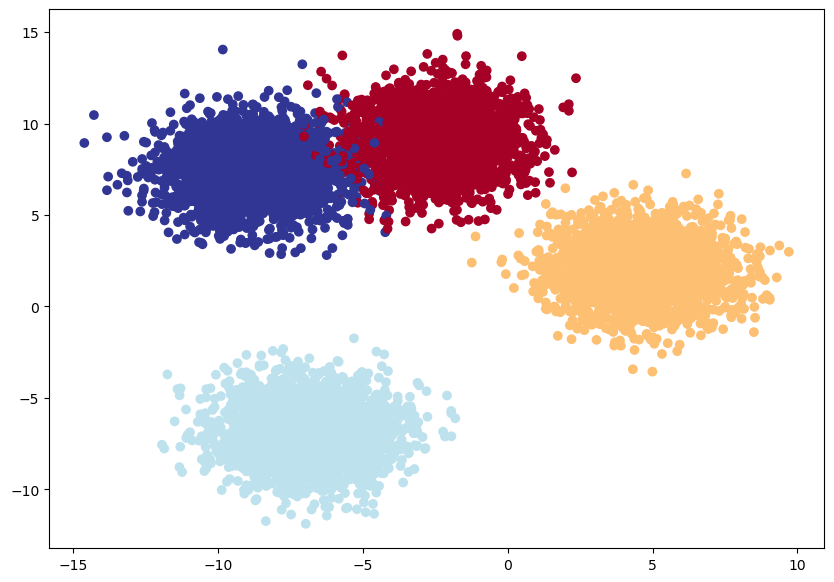

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# hyperparams
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
NUM_SAMPLES = 10000
CLUSTER_RANDOMNESS = 1.5
LEARING_RATE = 0.01

# create multiclass data
X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std=CLUSTER_RANDOMNESS, # randomness
                            random_state=RANDOM_SEED)

# turn into Tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# split into train / test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                                        y_blob, 
                                                                        test_size=0.2, 
                                                                        random_state=RANDOM_SEED)

# plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

import torch.nn as nn

# multi class classification model in pytorch
class BlobModel(nn.Module):
    def __init__(self, in_features, output_features, hidden_units=8):
        """Initialises multi-class classification model

        Args:
            input_features (int): Number of input features
            output_features (int): Number of output features
            hidden_units (int): Number of hidden units between layers, default 8

        Returns:

        Example:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

print(f"Running on device {device}")

Running on device cpu


In [3]:
X_blob_train.shape, torch.unique(y_blob_train)

(torch.Size([8000, 2]), tensor([0, 1, 2, 3]))

In [4]:
model_4 = BlobModel(in_features=2, 
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [5]:
# loss function and optimiser

loss_fn = nn.CrossEntropyLoss()

# optimiser
optimiser = torch.optim.SGD(params=model_4.parameters(), lr=LEARING_RATE)

In [6]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [7]:
# getting prediction probs for multi class pytorch model
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device)) # logits

y_logits[:10]

tensor([[ 1.6472,  1.1239,  1.9727, -1.6448],
        [ 0.8409,  0.6746,  1.1702, -0.8033],
        [ 1.2016,  0.9488,  1.3396, -1.1493],
        [ 0.0289,  1.1213,  0.8736, -0.6225],
        [ 0.3787,  2.5835,  1.3166, -1.5525],
        [ 1.5393,  1.0759,  1.8326, -1.5273],
        [ 0.3474,  2.0492,  1.0337, -1.1742],
        [ 0.8780,  0.7551,  1.0378, -0.8188],
        [ 1.3452,  0.9543,  1.6643, -1.3313],
        [ 1.2930,  0.9418,  1.5711, -1.2697]])

In [8]:
y_blob_test[:10]

tensor([1, 1, 1, 2, 3, 1, 3, 1, 1, 1])

In [9]:
# logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 1.6472,  1.1239,  1.9727, -1.6448],
        [ 0.8409,  0.6746,  1.1702, -0.8033],
        [ 1.2016,  0.9488,  1.3396, -1.1493],
        [ 0.0289,  1.1213,  0.8736, -0.6225],
        [ 0.3787,  2.5835,  1.3166, -1.5525]])
tensor([[0.3317, 0.1966, 0.4594, 0.0123],
        [0.2916, 0.2469, 0.4052, 0.0563],
        [0.3311, 0.2572, 0.3801, 0.0316],
        [0.1464, 0.4365, 0.3407, 0.0763],
        [0.0783, 0.7103, 0.2001, 0.0114]])


In [10]:
torch.sum(y_pred_probs[0]) # probabilities sum to 1

tensor(1.0000)

In [11]:
# convert prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([2, 2, 2,  ..., 1, 1, 1])

In [12]:
# Training and Testing Loop for multi class model
epochs = 5001

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)


In [13]:
# Training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_4.train()

    # Forward pass
    y_logits = model_4(X_blob_train)
    # logits -> pred_probs -> pred_labels
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    # Calculate loss / accuracy
    loss = loss_fn(y_logits, y_blob_train) # BCEWithLogitsLoss
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    # Optimiser zero grad
    optimiser.zero_grad()

    # Loss backward (back propogation) calculate the gradients
    loss.backward()

    # Optimiser step - updates model params
    optimiser.step()


    # Testing
    model_4.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # Calculate test loss / accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Acc: {test_acc:.2f}")
    

Epoch: 0 | Loss: 1.9991, Acc: 2.05 | Test Loss: 1.91481, Acc: 3.10
Epoch: 1000 | Loss: 0.0413, Acc: 98.79 | Test Loss: 0.04872, Acc: 98.30
Epoch: 2000 | Loss: 0.0338, Acc: 98.88 | Test Loss: 0.04276, Acc: 98.30
Epoch: 3000 | Loss: 0.0316, Acc: 98.90 | Test Loss: 0.04117, Acc: 98.35
Epoch: 4000 | Loss: 0.0305, Acc: 98.91 | Test Loss: 0.04025, Acc: 98.35
Epoch: 5000 | Loss: 0.0297, Acc: 98.91 | Test Loss: 0.03956, Acc: 98.50


In [14]:
y_preds.size()

torch.Size([2000])

In [15]:
# make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

#view first 10
y_logits[:10]

tensor([[  7.0009,  22.3888,   0.2309, -15.2215],
        [  3.3241,  12.5226,   0.6111,  -8.4443],
        [  5.0523,  15.1114,  -0.1025, -10.1309],
        [ -0.8678,  -5.4229,   7.8072,   0.9947],
        [  7.2327, -17.1225,   2.6903,  15.6686],
        [  6.5293,  20.7584,   0.1833, -14.0838],
        [  7.2861, -10.7972,   1.0805,  10.5496],
        [  3.6412,  11.3971,   0.0562,  -7.5747],
        [  5.6832,  18.6488,   0.3132, -12.6425],
        [  5.4544,  17.6109,   0.2249, -11.9089]])

In [16]:
# go from logits -> Prediction Probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.0755e-07, 1.0000e+00, 2.3821e-10, 4.6351e-17],
        [1.0119e-04, 9.9989e-01, 6.7120e-06, 7.8369e-10],
        [4.2795e-05, 9.9996e-01, 2.4700e-07, 1.0899e-11],
        [1.7058e-04, 1.7935e-06, 9.9873e-01, 1.0985e-03],
        [2.1688e-04, 5.7398e-15, 2.3093e-06, 9.9978e-01],
        [6.6125e-07, 1.0000e+00, 1.1597e-09, 7.3829e-16],
        [3.6843e-02, 5.1625e-10, 7.4349e-05, 9.6308e-01],
        [4.2802e-04, 9.9956e-01, 1.1872e-05, 5.7606e-09],
        [2.3395e-06, 1.0000e+00, 1.0888e-08, 2.5724e-14],
        [5.2538e-06, 9.9999e-01, 2.8143e-08, 1.5126e-13]])

In [17]:
# pred probs to pred labels
#y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds = y_pred_probs.argmax(dim=1) # either works
y_preds[:10]

tensor([1, 1, 1, 2, 3, 1, 3, 1, 1, 1])

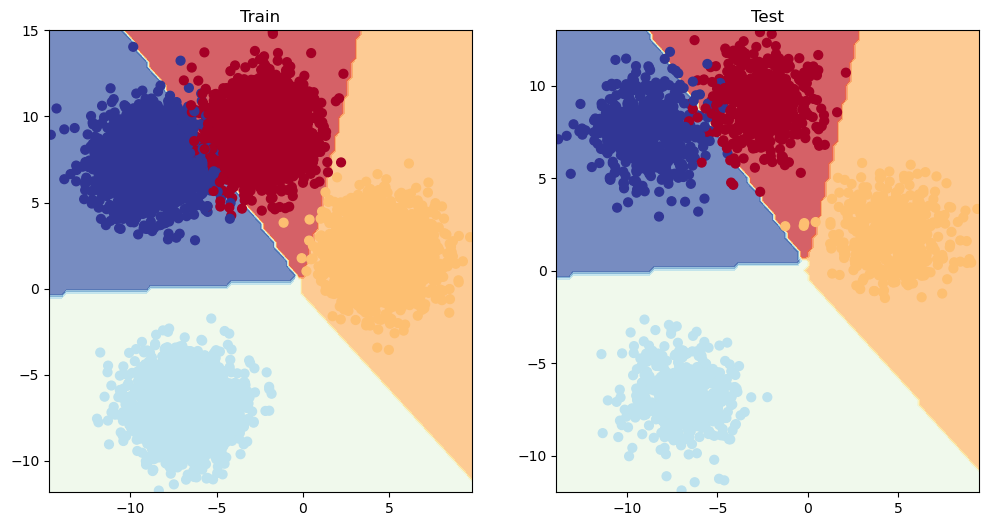

In [18]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# More classification metrics
* Accuracy - how many correct out of 100
* Precision
* Recall
* F1-score
* Confusion Metrics
* Classification report

torchmetrics

In [24]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9850)

In [27]:
from torchmetrics.classification import MulticlassConfusionMatrix

confmat = MulticlassConfusionMatrix(num_classes=4).to(device)

confmat(y_preds, y_blob_test)

tensor([[487,   0,   0,  13],
        [  4, 505,   0,   0],
        [  0,   0, 475,   0],
        [ 13,   0,   0, 503]])